# Use spectra of CTIO Data in November 2016 to do atmospheric studies
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 16th 2017


This notebook is supposed to perform an atmospheric properties measurement on spectra

- under development


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import pandas as pd

In [2]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [3]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.interpolate import interp1d

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [6]:
%load_ext Cython

In [7]:
from IPython.display import Image, display

In [8]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [9]:
from scipy.interpolate import interp1d

In [10]:
import datetime
from dateutil import parser  # very usefull time format smart parser

In [11]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [12]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [15]:
inputdir="./spectrum_calibcompsimrealspec"
object_name='HD14943'

In [16]:
outputdir="./spectrum_ana"

In [17]:
ensure_dir(outputdir)

In [18]:
output_file='AnaAtmFromSpectra_'+object_name+'.csv'

## Location of calibrated spectra and Simulations
----------------------------------

In [19]:
input_filelist=os.listdir(inputdir) 

In [20]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [21]:
print input_filelist[0:5]

['compSimRealSpectra_HD14943_20170117_092.fits'
 'compSimRealSpectra_HD14943_20170117_093.fits'
 'compSimRealSpectra_HD14943_20170117_094.fits'
 'compSimRealSpectra_HD14943_20170117_095.fits'
 'compSimRealSpectra_HD14943_20170117_096.fits']


In [22]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [23]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [24]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [25]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [26]:
print indexes_files

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104]


In [27]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [28]:
sorted_numbers=indexes_files[sorted_indexes]

In [29]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]


In [30]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [31]:
sorted_files[0:5]

array([ './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_092.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_093.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_094.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_095.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_096.fits'], 
      dtype='|S76')

## Build full filename
----------------------------

In [32]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [33]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [34]:
print sorted_filenames.shape

(104,)


## Acces to spectrum data
----------------------------------

In [35]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [36]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra_data = []
    all_rightspectra_data = []
    all_leftspectra_sim = []
    all_rightspectra_sim = []
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        #cols = hdu_list[1].columns
        #cols.info()
        #print hdu_list[1].columns
        #cols.names
  
        #col1=fits.Column(name='CalibLeftSpecWL',format='E',array=theleftwl_cut[idx[0]])
        #col2=fits.Column(name='CalibLeftSpecData',format='E',array=theleftspectrum_cut[idx[0]])
        #col3=fits.Column(name='CalibLeftSpecSim',format='E',array=theleftsimspec_cut[idx[0]])
        #col4=fits.Column(name='CalibRightSpecWL',format='E',array=therightwl_cut[idx[0]])
        #col5=fits.Column(name='CalibRightSpecData',format='E',array=therightspectrum_cut[idx[0]])
        #col6=fits.Column(name='CalibRightSpecSim',format='E',array=therightsimspec_cut[idx[0]])
    
    
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum_data=table_data.field('CalibLeftSpecData')
        left_spectrum_sim=table_data.field('CalibLeftSpecSim')
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum_data=table_data.field('CalibRightSpecData')
        right_spectrum_sim=table_data.field('CalibRightSpecSim')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra_data.append(left_spectrum_data)
        all_rightspectra_data.append(right_spectrum_data)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
        all_leftspectra_sim.append(left_spectrum_sim)
        all_rightspectra_sim.append(right_spectrum_sim)
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl, \
        all_rightspectra_wl

In [37]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl,all_rightspectra_wl=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

In [38]:
print len(all_dates)

104


## Show Spectra
-----------------------

In [39]:
NDATA=len(all_rightspectra_data)

In [40]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
def ShowSpectra(all_spectra,all_ssim,all_wl,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        spectrumsim=all_ssim[index]
        wl=all_wl[index]
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2,label='data')
        axarr[iy,ix].plot(wl,spectrumsim,'b-',lw=2,label='sim')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,200.)
        axarr[iy,ix].set_xlim(0.,1000.)
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
      
        
    
    #title='spectra'
    #plt.suptitle(title,size=16)
   

### Work only on right spectra

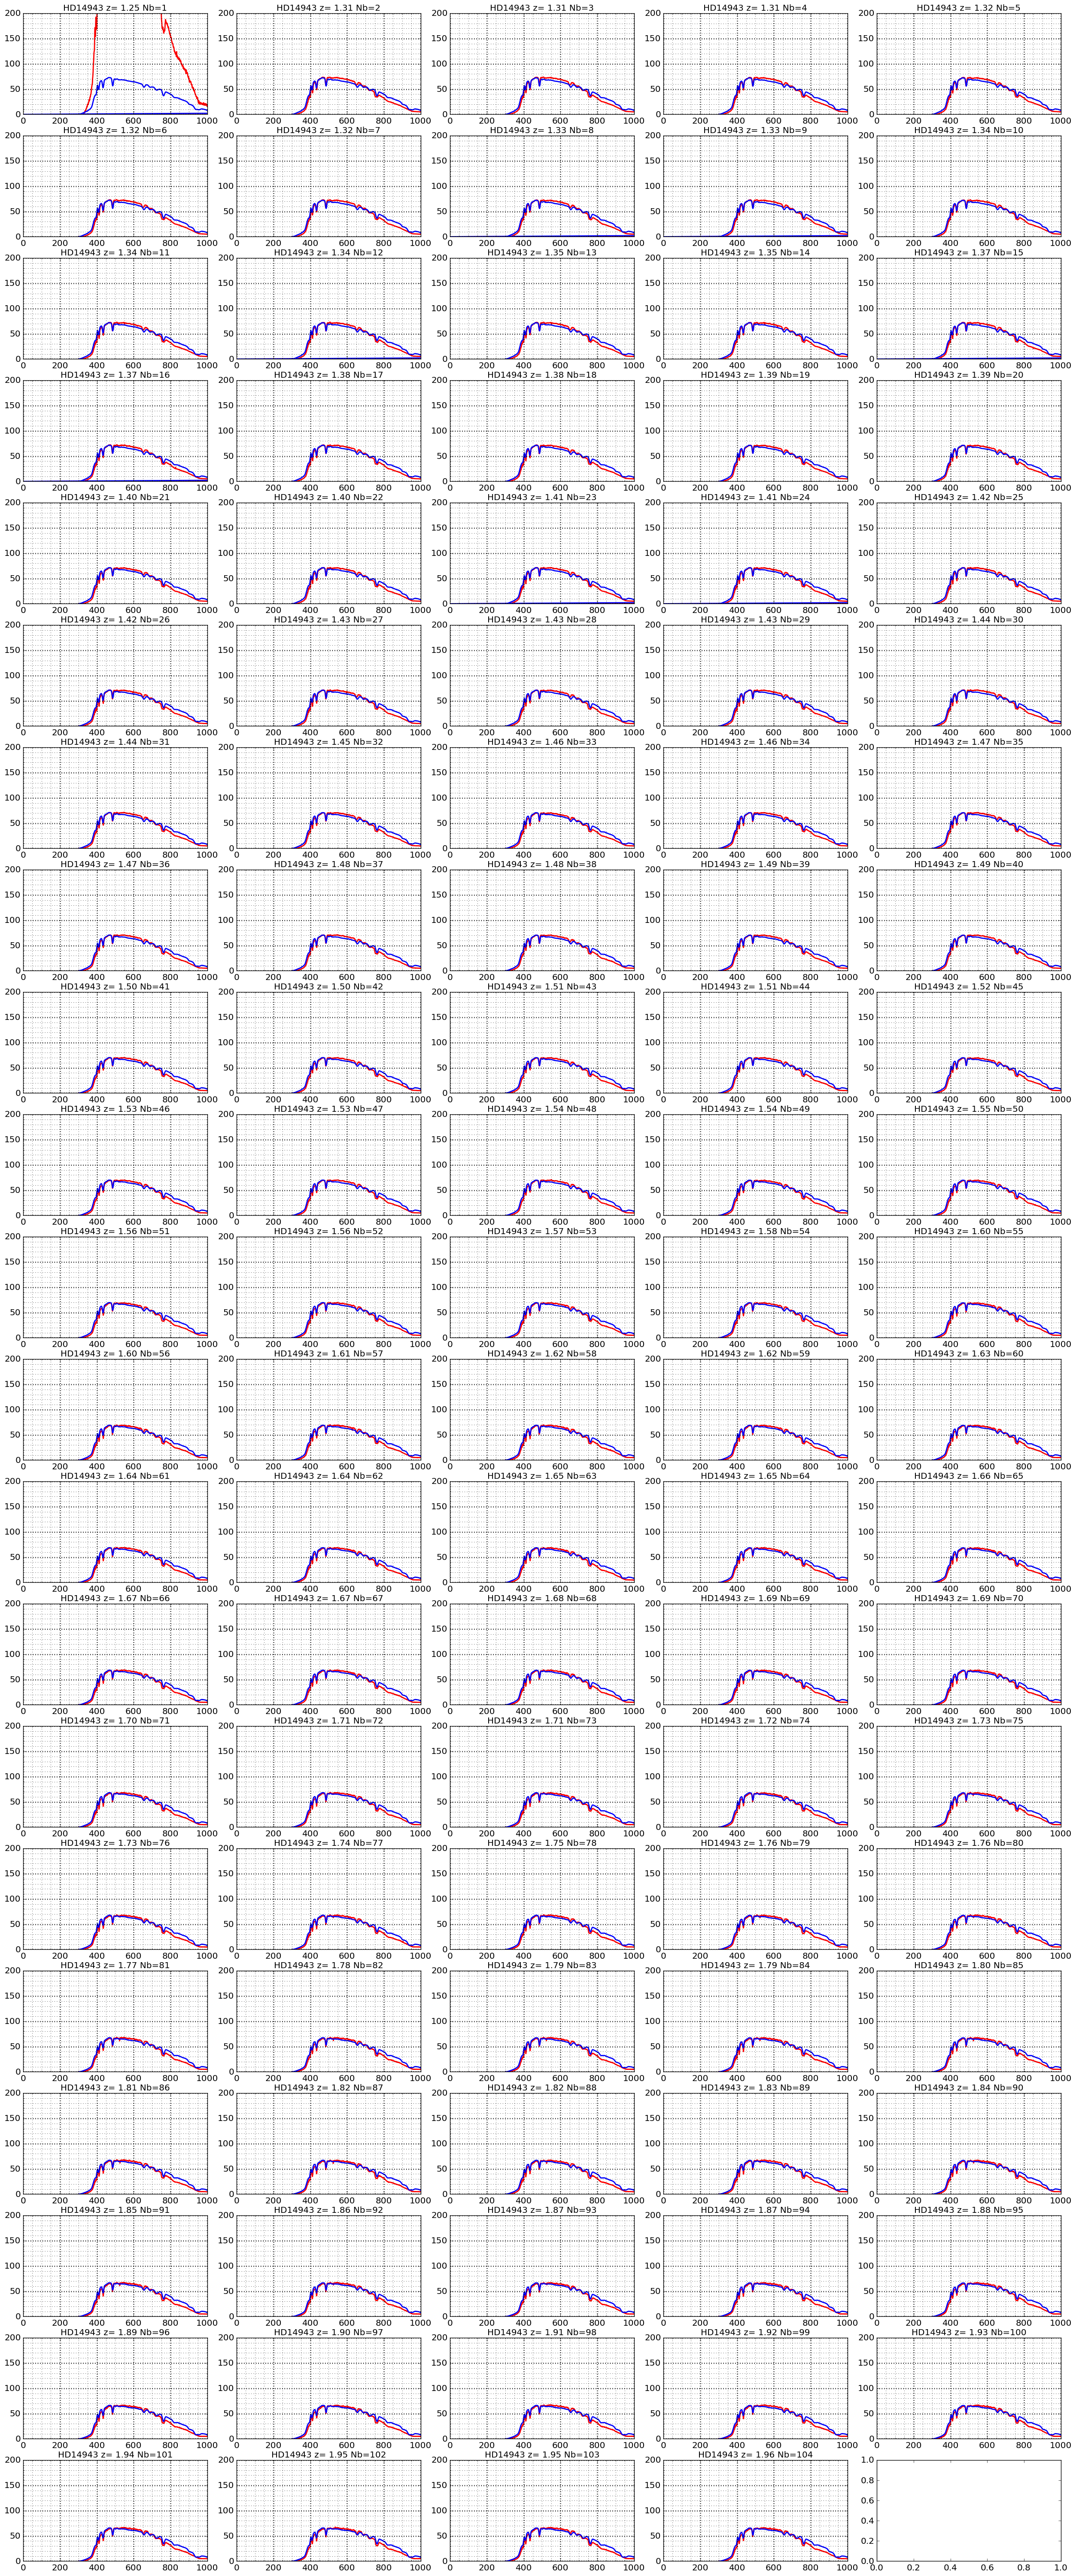

In [41]:
ShowSpectra(all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name)

In [42]:
wl_O2Aline=759.37      # Balmer Lines
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175
wl_Heline=397.0

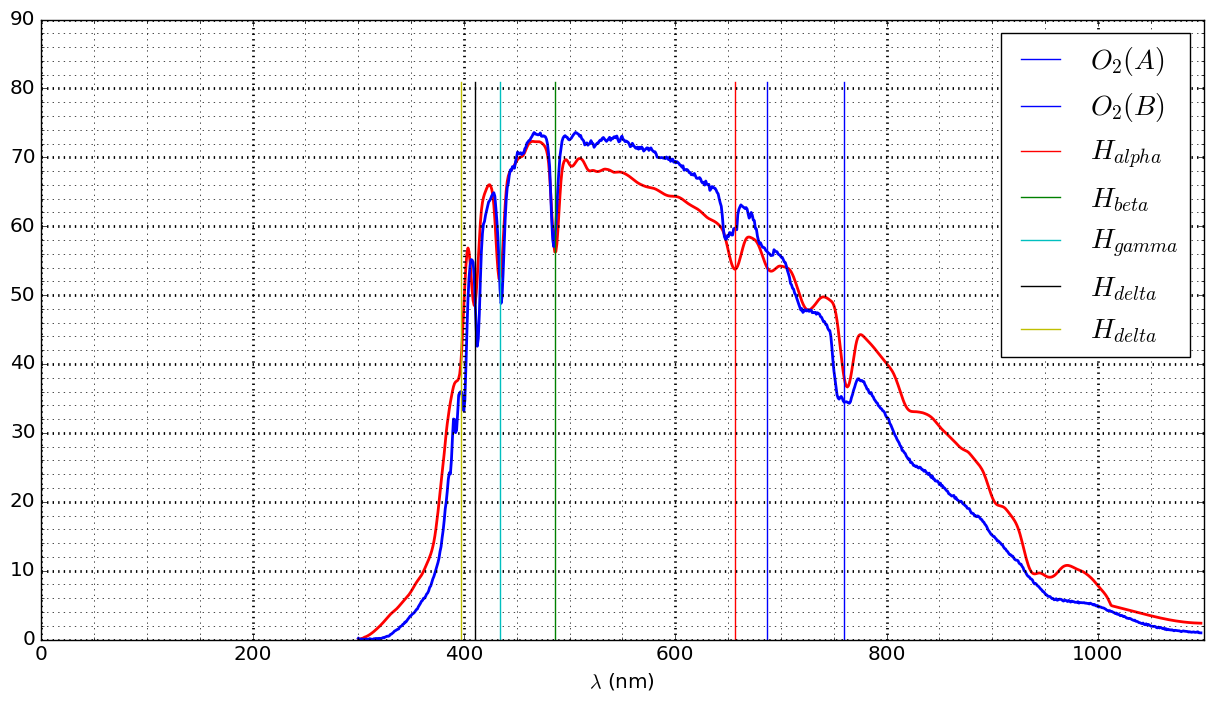

In [43]:
sel=1
thespectrum=all_rightspectra_data[sel]
thesimspectrum=all_rightspectra_sim[sel]

thewl=all_rightspectra_wl[sel]
ymin=thespectrum.min()
ymax=thespectrum.max()*1.1

fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.plot(thewl,thesimspectrum,'r-',lw=2)
ax.plot(thewl,thespectrum,'b-',lw=2)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y-',label='$H_{delta}$',lw=1)

ax.legend(loc='best',fontsize=20)
ax.set_xlim(0,1100)
ax.set_xlabel("$\lambda$ (nm)")

## Study ratio Data/Sim spectra

In [44]:
def ShowRatioSpectra(thewl,thespectrum,thesimspec,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
                  
        ratio=thespectrum[index]/thesimspec[index]
        all_ymin.append(ratio.min())
        all_ymax.append(ratio.max())
                       
        ax.plot(thewl[index],ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")

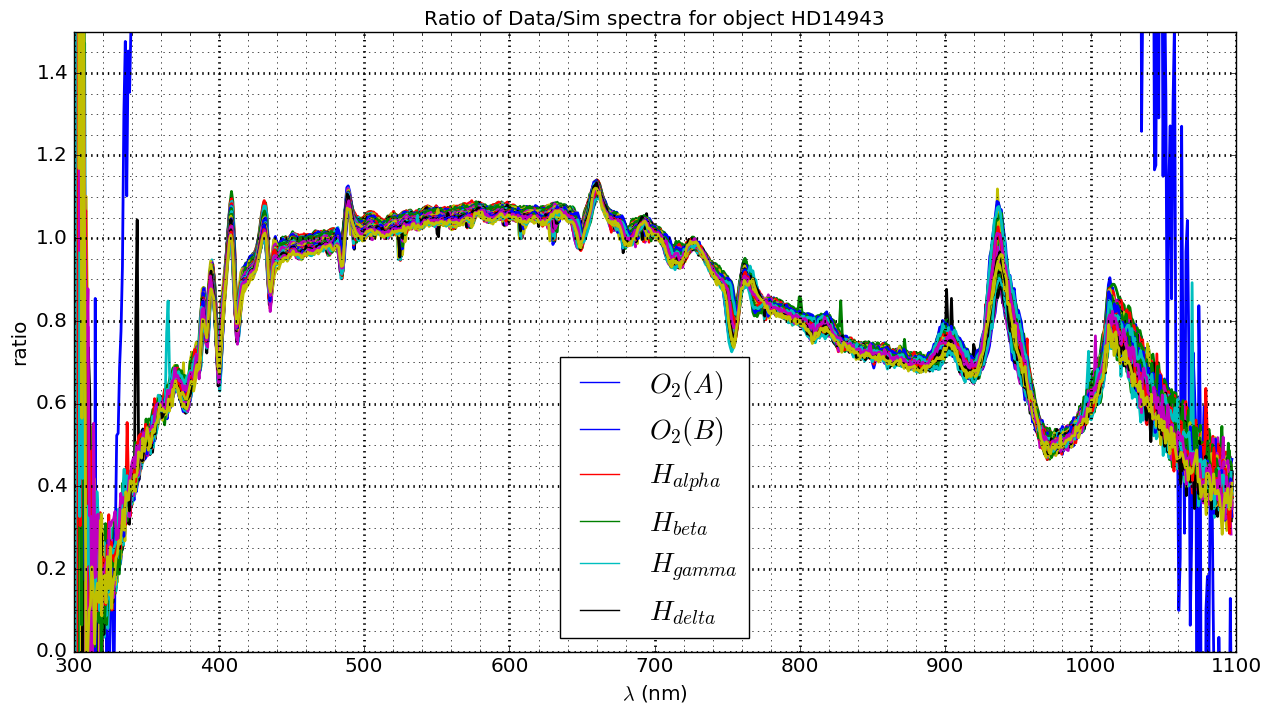

In [45]:
#all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name
ShowRatioSpectra(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,all_titles,object_name)




In [46]:
wlcut=400

In [47]:
np.where(all_rightspectra_wl[1]>wlcut)

(array([103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
        207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
        233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280

In [48]:
def ShowRatioSpectraSum(thewl,thespectrum,thesimspec,wlcut,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))

    all_ymin= []
    all_ymax=[]
    all_sum=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
         
        selectedindexes=np.where(all_rightspectra_wl[index]>wlcut)    
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=all_rightspectra_wl[index][selectedindexes]
        
        ratio=sel_data/sel_sim
        all_ymin.append(ratio.min())
        all_ymax.append(ratio.max())
        all_sum.append(ratio.mean())
                       
        ax.plot(sel_wl,ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    plt.plot(all_sum,'ro')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    title='Average of Ratio of Data/Sim spectra over wavelegth for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio average ")
    ax.set_xlabel(" image number")
    return np.array(all_sum)

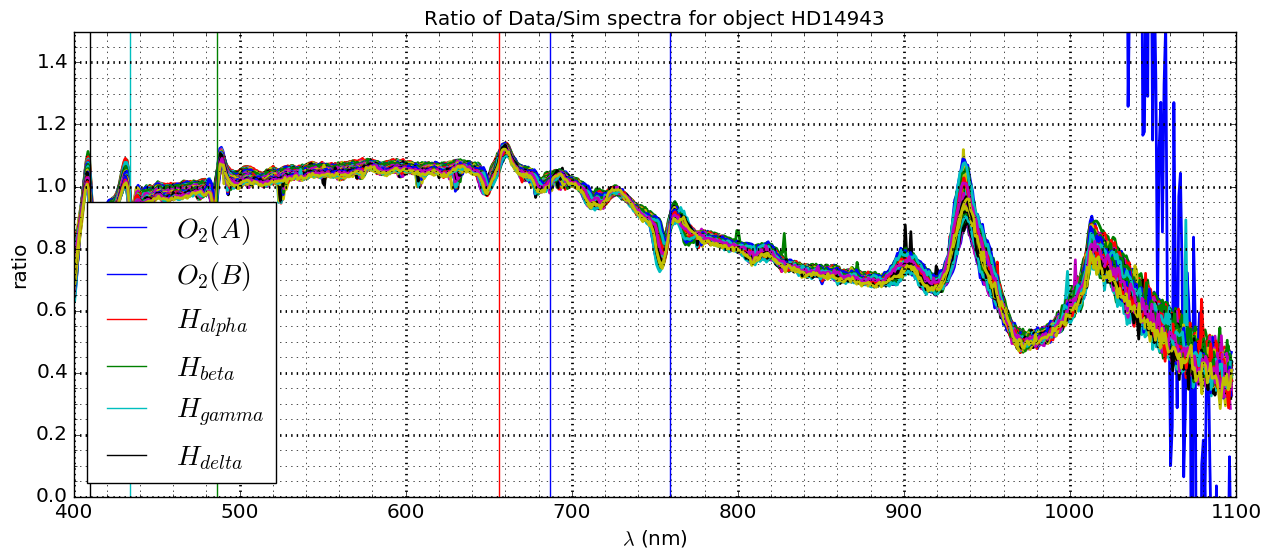

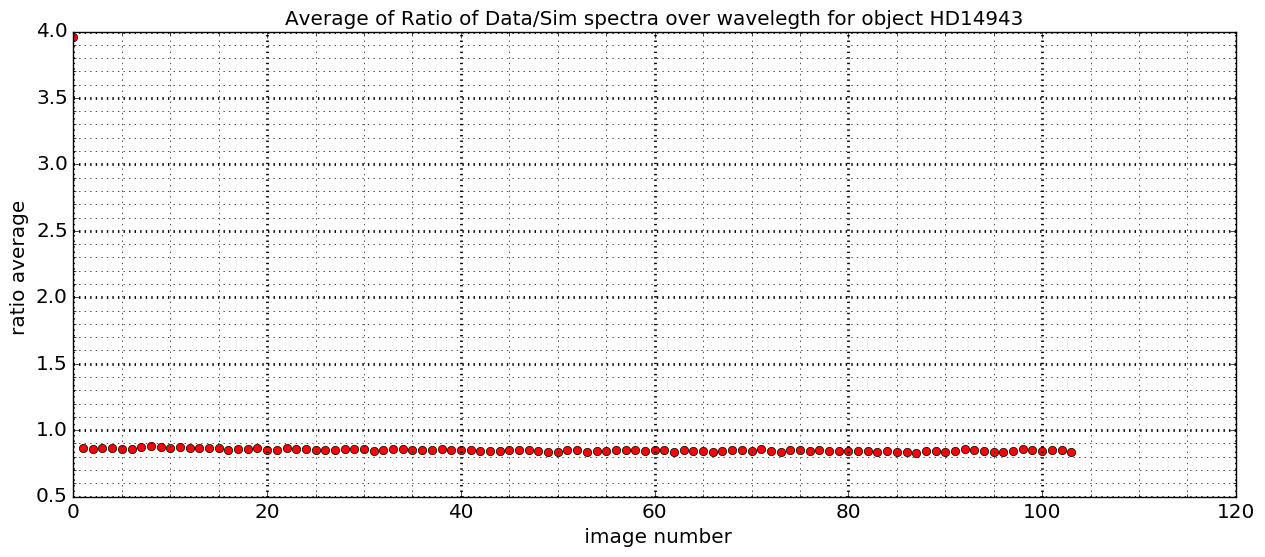

In [49]:
all_ratioaver=ShowRatioSpectraSum(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

In [50]:
#datetime.date(all_dates)

In [51]:
#from dateutil import parser
#dt = parser.parse("Aug 28 1999 12:00AM")

In [52]:
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

In [76]:
all_dt

[datetime.datetime(2017, 1, 18, 2, 1, 59, 245000),
 datetime.datetime(2017, 1, 18, 2, 21, 39, 966000),
 datetime.datetime(2017, 1, 18, 2, 22, 53, 476000),
 datetime.datetime(2017, 1, 18, 2, 24, 6, 986000),
 datetime.datetime(2017, 1, 18, 2, 25, 20, 499000),
 datetime.datetime(2017, 1, 18, 2, 26, 34, 11000),
 datetime.datetime(2017, 1, 18, 2, 27, 47, 530000),
 datetime.datetime(2017, 1, 18, 2, 29, 1, 44000),
 datetime.datetime(2017, 1, 18, 2, 30, 14, 556000),
 datetime.datetime(2017, 1, 18, 2, 31, 28, 67000),
 datetime.datetime(2017, 1, 18, 2, 32, 41, 584000),
 datetime.datetime(2017, 1, 18, 2, 33, 55, 106000),
 datetime.datetime(2017, 1, 18, 2, 35, 8, 623000),
 datetime.datetime(2017, 1, 18, 2, 36, 22, 144000),
 datetime.datetime(2017, 1, 18, 2, 41, 34, 869000),
 datetime.datetime(2017, 1, 18, 2, 42, 48, 381000),
 datetime.datetime(2017, 1, 18, 2, 44, 1, 894000),
 datetime.datetime(2017, 1, 18, 2, 45, 15, 411000),
 datetime.datetime(2017, 1, 18, 2, 46, 28, 933000),
 datetime.datetime(2

In [80]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
mins=mdates.MinuteLocator()
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')


In [81]:
am=np.array(all_airmass)*.25

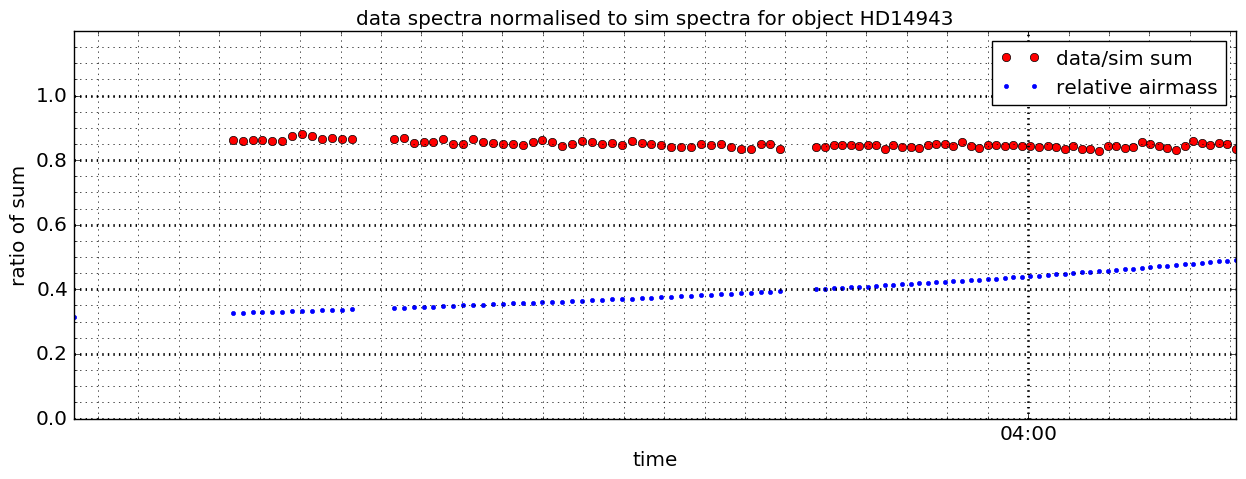

In [83]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, all_ratioaver,marker='o',color='red',lw=0,label='data/sim sum',linewidth=3)
ax.plot_date(all_dt, am,marker='.',color='blue',lw=0,label='relative airmass',linewidth=3)

ax.set_ylim(0,1.2)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('ratio of sum')
ax.set_xlabel('time')


title='data spectra normalised to sim spectra for object {}'.format(object_name)

plt.title(title)
plt.legend(loc='best')

#plt.savefig(figfilename1, bbox_inches='tight')

In [58]:
imgindex_max=np.where(all_ratioaver==all_ratioaver.max())[0][0]

In [59]:
imgindex_min=np.where(all_ratioaver==all_ratioaver.min())[0][0]

In [60]:
print imgindex_max, imgindex_min

0 87


In [61]:
len(all_rightspectra_wl[0])

812

In [62]:
wlcutmax=all_rightspectra_wl[imgindex_max].max()

In [63]:
wlcutmax

1097.074

In [64]:
def ShowRatioSpectraNorm(idx,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ShowRatioSpectraNorm: Show the calibration curve Normalisation
    ==============
    """

    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    ratio_sel0=thespectrum[idx]/thesimspec[idx]
    interpol_ratio=interp1d(all_rightspectra_wl[idx],ratio_sel0)
    wlcutmax=all_rightspectra_wl[idx].max()-1.
    
    selectedindexes0=np.where(np.logical_and(all_rightspectra_wl[idx]>wlcutmin, all_rightspectra_wl[idx]<wlcutmax))     
    
    sel_wl0=all_rightspectra_wl[idx][selectedindexes0]
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    
    
    # 2nd plot
    fig, ax = plt.subplots(1, 1, figsize=(15,6))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
     
    
    for index in np.arange(0,NBSPECTRA):
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        
        selectedindexes=np.where(np.logical_and(all_rightspectra_wl[index]>wlcutmin, all_rightspectra_wl[index]<wlcutmax))     
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=all_rightspectra_wl[index][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
                       
        ax.plot(sel_wl,ratioratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    return all_ratiowl,all_ratioratio


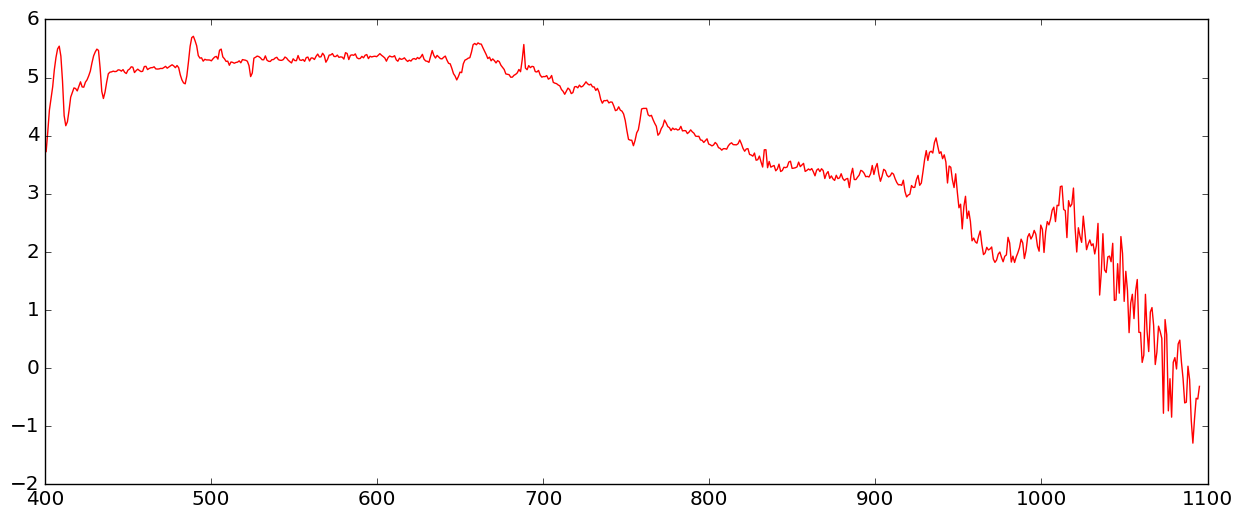

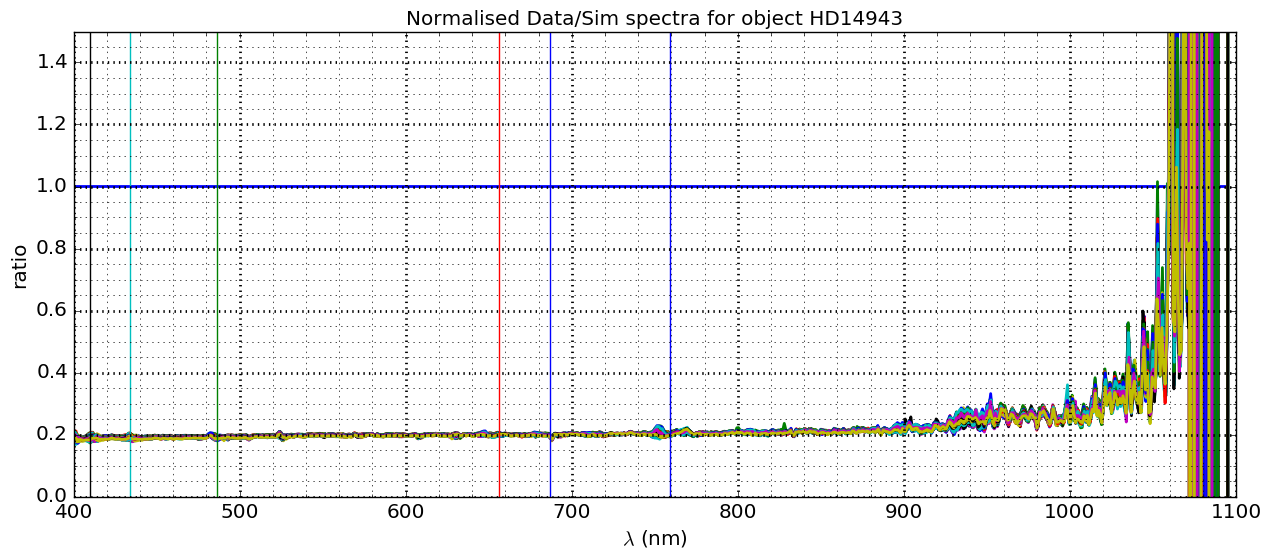

In [65]:
all_ratiowl,all_ratioratio=ShowRatioSpectraNorm(imgindex_max,all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

In [66]:
def GetAtmProperties(wlmin,wlmax,wlcoll,datacoll):
    
    NDATA=len(datacoll)
    outputcoll = []
    for i in range(NDATA):
        
        wl=wlcoll[i]
        data=datacoll[i]
        selectedindex=np.where(np.logical_and(wl>wlmin,wl<wlmax))
        datasel=data[selectedindex]
        dataaver=datasel.mean()
        outputcoll.append(dataaver)
        
    return np.array(outputcoll)
        
    

In [67]:
AtmClouds=GetAtmProperties(500.,900.,all_ratiowl,all_ratioratio)

In [68]:
AtmH2O_900=GetAtmProperties(900.,960.,all_ratiowl,all_ratioratio)

In [69]:
AtmH2O_1000=GetAtmProperties(1000.,1100.,all_ratiowl,all_ratioratio)

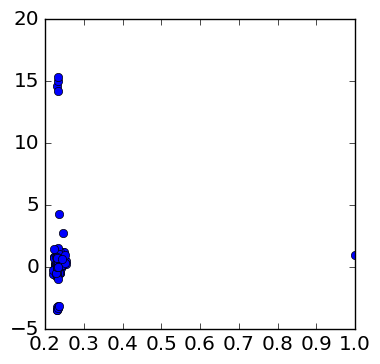

In [70]:
plt.plot(AtmH2O_900,AtmH2O_1000,'o')

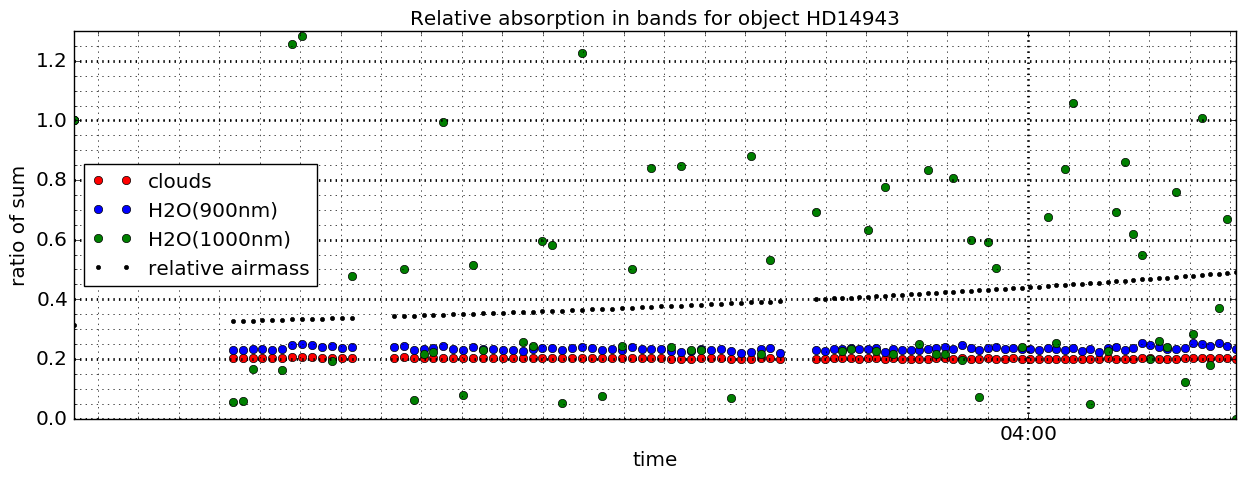

In [84]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, AtmClouds,marker='o',color='red',lw=0,label='clouds',linewidth=0)
ax.plot_date(all_dt, AtmH2O_900,marker='o',color='blue',lw=0,label='H2O(900nm)',linewidth=0)
ax.plot_date(all_dt, AtmH2O_1000,marker='o',color='green',lw=0,label='H2O(1000nm)',linewidth=0)

ax.plot_date(all_dt, am,marker='.',color='black',lw=0,label='relative airmass',linewidth=3)

ax.set_ylim(0,1.3)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('ratio of sum')
ax.set_xlabel('time')


title='Relative absorption in bands for object {}'.format(object_name)

plt.title(title)
plt.legend(loc='best')

#plt.savefig(figfilename1, bbox_inches='tight')

In [72]:
atm_data = {'clouds' : AtmClouds , 'H2O_900nm' :AtmH2O_900, 'H2O_1000nm' :AtmH2O_1000}

In [73]:
df=pd.DataFrame(atm_data,index=all_dates)
df.index.name='date'

In [75]:
df

,H2O_1000nm,H2O_900nm,clouds
date,,,
2017-01-18T02:01:59.245,1.000000,1.000000,1.000000
2017-01-18T02:21:39.966,0.055074,0.229868,0.204351
2017-01-18T02:22:53.476,0.058272,0.229424,0.204314
2017-01-18T02:24:06.986,0.167530,0.232372,0.204139
2017-01-18T02:25:20.499,-0.147497,0.234068,0.204132
2017-01-18T02:26:34.011,1.461574,0.231240,0.203579
2017-01-18T02:27:47.530,0.163503,0.231665,0.203718
2017-01-18T02:29:01.044,1.255980,0.246493,0.205161
2017-01-18T02:30:14.556,1.283039,0.249477,0.206166


In [ ]:
df.describe()

In [ ]:
df.to_csv(output_file)